# Make spatial correlations between variables
conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 600 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

list_vars = ['tas', 'snc', 'pr']
table = [None]*len(list_vars); label = [None]*len(list_vars); units = [None]*len(list_vars); 
cmap = [None]*len(list_vars); levels = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    table[i] = u.get_table(var)
    label[i], units[i], cmap[i], levels[i] = u.get_var_infos(var)

## Load topography

In [26]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
# elevation_std = ds.elevation_stddev

## Load results

In [18]:
# mmm: multimodel mean (is at the last index)
# It is removed here .isel(model=slice(0,-1))

bias = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    bias[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
    ).isel(model=slice(0,-1))
    bias[i].name = var

## Create DataFrame to save correlation results

In [217]:
corr_labels = ['tas/snc', 'tas/pr', 'snc/pr']
index_corr = np.array(corr_labels*len(seasons))
index_seasons = np.array([[season]*len(corr_labels) for season in seasons]).flatten()

indexes = [index_seasons, index_corr]

temp = np.empty((indexes[0].size, bias[0].model.size))
temp[:] = np.nan

df = pd.DataFrame(temp, index = indexes, columns = bias[0].model.values)
df

BCC-CSM2-MR  BCC-ESM1  CAS-ESM2-0  CESM2  CESM2-FV2  \
Annual tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   
DJFMA  tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   
JJAS   tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   

                CESM2-WACCM  CESM2-WACCM-FV2  CNRM-CM6-1  CNRM-CM6-1-HR  \
Annual tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   
DJFMA  tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   
JJAS   tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   

                CNRM-ESM2-1  ...  IPSL-CM6A-LR  MIROC-ES2L  MIROC6  \
Annual tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   
DJFMA  tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   
JJAS   tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   

                MPI-ESM1-2-HR  MPI-ESM1-2-LR  MRI-ESM2-0  NorESM2-LM  \
Annual tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   
DJFMA  tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   
JJAS   tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   

                SAM0-UNICON  TaiESM1  UKESM1-0-LL  
Annual tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  
DJFMA  tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  
JJAS   tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  

[9 rows x 27 columns]

## Compute correlations

In [190]:
list_vars

['tas', 'snc', 'pr']

In [191]:
corr_labels

['tas/snc', 'tas/pr', 'snc/pr']

In [214]:
pairs = [[0, 1], [0, 2], [1, 2]]

In [224]:
%%time
for season in seasons:
# for season in ['Annual']:
    print(season)
    for k, pair in enumerate(pairs):
        print(corr_label)
        print(k)
        for model in bias[0].model.values:
#             print(model)
            # Get all values for HMA (>2500m) and flatten the values
            x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()
            y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

            # Remove the nans
            x = x[~np.isnan(x)]
            y = y[~np.isnan(y)]

            # Get rvalue
            df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue

Annual
tas/snc
0
tas/snc
1
tas/snc
2
DJFMA
tas/snc
0
tas/snc
1
tas/snc
2
JJAS
tas/snc
0
tas/snc
1
tas/snc
2
CPU times: user 3.06 s, sys: 33 ms, total: 3.09 s
Wall time: 4.73 s


## Heatmap

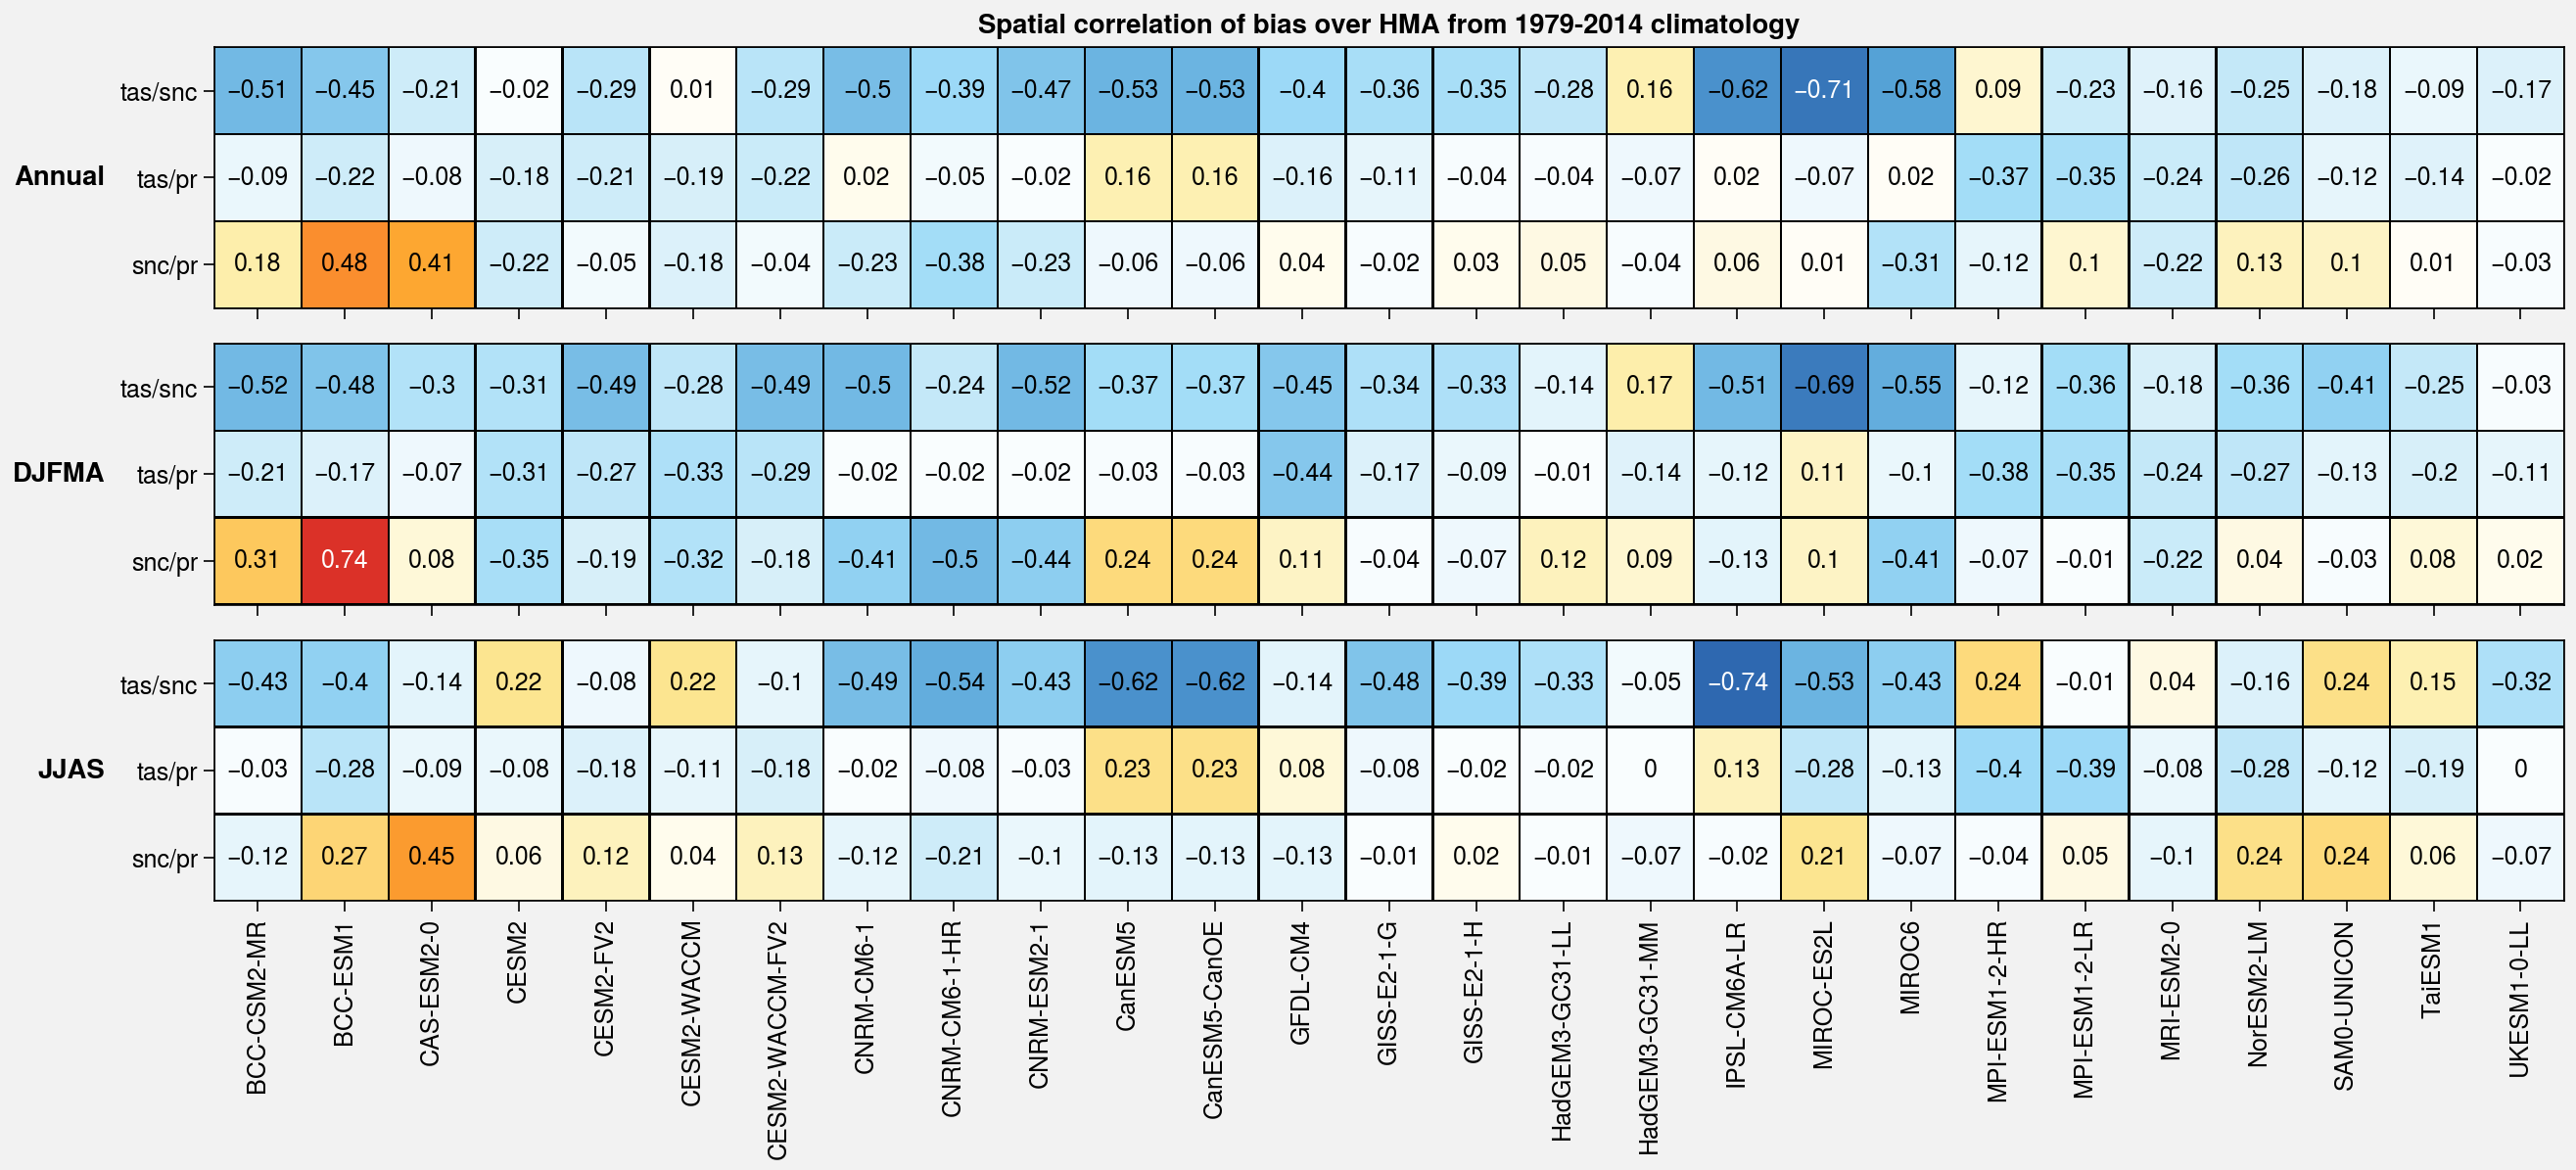

In [231]:
fig, axs = plot.subplots(nrows=3, ncols=1, axwidth=12)

for i, ax in enumerate(axs):
    ax.heatmap(
        df.loc[seasons[i]], 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True,
    )

axs.format(
    xrotation=90, rowlabels=seasons, yreverse=True,
    suptitle='Spatial correlation of bias over HMA from '+period.start+'-'+period.stop+' climatology', 
#     ticklabelsize=10, suptitlesize=11, title=' '
)

filename = 'correlation_bias_'+period.start+'-'+period.stop
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')